# Lonlat ms diagnosis on main combination

In [67]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, lonlat_stats
from histlib.cstes import labels, zarr_dir, matchup_dir, c0

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='00:30:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.0.145:36009' processes=0 threads=0, memory=0 B>

In [215]:
cluster.close()

In [3]:
DL, DT = 25e3, 30*60
comb_25 = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}

df= dd.read_csv(path_csv(comb_25, 'both', True, DL, DT)).repartition(npartitions=10).persist()

In [56]:
def mean_df(df):
    return df.mean()
from scipy.stats import bootstrap
def compute_bootstrap_error(dff):
    #print(len(dff))
    if len(dff)<3:
        return np.nan
    else : 
        data = (dff, )  # samples must be in a sequence
        return bootstrap(data, statistic = mean_df).standard_error

def lonlat_stats(df, dl=5, vars_errors=['S']):
    df["latbin"] = (df.lat // dl) * dl
    df["lonbin"] = (df.lon // dl) * dl
    
    # Mean in bins
    mean = df.groupby(["latbin", "lonbin"]).mean().compute()
    
    #count
    count = df.reset_index()[['obs', 'latbin', 'lonbin']].groupby(["latbin", "lonbin"]).count().obs.compute().rename('nb_coloc_bin')

    # bootstrap errors
    DF = []
    for v in vars_errors :
        DF.append(df.reset_index()[['S', 'latbin', 'lonbin']].groupby(["latbin", "lonbin"])[v].apply(compute_bootstrap_error).compute())
    booterrors = pd.concat(DF, axis=1)
    booterrors = booterrors.rename(columns={v:'be__'+v for v in booterrors.columns})

    return pd.concat([mean, count,booterrors], axis=1)

______________________
# Fig function

In [112]:
def plot_total_lonlat_hist(var, ax, bins=30) :
    v = var.values.ravel()
    v = v[~np.isnan(v)]
    hist, bedge = np.histogram(v, bins=bins)
    ax.plot(bedge[:-1] + (bedge[1]-bedge[0])/2, hist)

def plot_lonlat(var,ax, letter=None, retins=False, **kwargs):
    dkwargs = dict(cmap='viridis')
    dkwargs.update(kwargs)
    var.plot(ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    if letter : 
        put_fig_letter(fig, ax, letter)
    ins = ax.inset_axes(ins_ax_box)
    plot_total_lonlat_hist(var, ins)
    ins.grid()
    ins.set_yticks([])
    ins.set_xlabel('')
    bbox = dict(ec="w", fc="w", alpha=0.8)
    plt.setp(ins.get_xticklabels(), bbox=bbox)
    ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')
    ins.xaxis.get_offset_text().set(bbox=bbox)
    if retins:
        return ins

## Inserted box
#ins_ax_box = [0.66,0.73,0.25,0.27]
ins_ax_box = [0.56,0.7,0.29,0.3]

_________
# Compute all 

In [59]:
dfm = lonlat_stats(df, dl=5, vars_errors=['S'])

In [209]:
dsm = dfm.to_xarray()

In [210]:
dsm['ratio__S'] = dsm['be__S']/dsm['S']

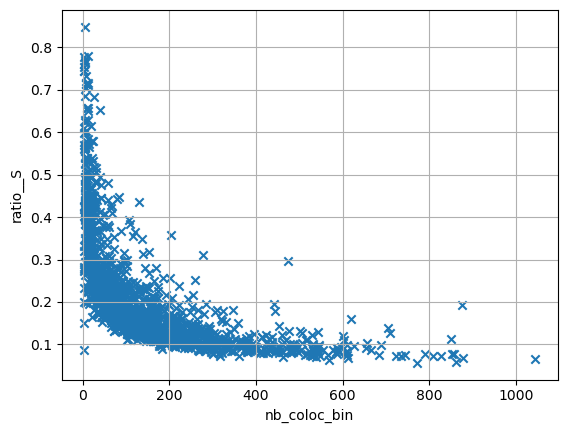

In [211]:
dsm.plot.scatter(x='nb_coloc_bin', y='ratio__S', marker='x')
plt.grid()

In [212]:
test = dsm['ratio__S']<0.2 # keep only bins where S relative error is below 20%
ds = dsm.where(dsm['ratio__S']<0.2)

In [213]:
for v in [v for v in dsm if 'X' in v] :
    ds[v+'__sigma'] = ds[v]/ds['sigma']*100

_________
# Select areas

In [88]:
# Gulf Stream 
area_geo = ds['X_cor_ggx__sigma']>70
gulf_stream = area_geo.where(area_geo.lonbin<-10, False).where(area_geo.latbin>15, False).where(area_geo.lonbin>-85, False).where(area_geo.latbin<50, False)
# ACC 
testlat = (ds.latbin<-35)
area_geo = ds['X_cor_ggx__sigma']>45
acc = area_geo.where(testlat, False)
# North Pacific
area_geo = ds['X_acc_cor__sigma']>10
testlon = (ds.lonbin<-120)| (ds.lonbin>150)
testlat = (ds.latbin>40)
north_pacific = area_geo.where(testlat & testlon, False)
# Tropics
testlat = (ds.latbin<15)&(ds.latbin>-15)
tropics = ds['X_cor_ggx__sigma'].where(testlat, False)

areas = {'GS':gulf_stream, 'ACC':acc, 'NP':north_pacific, 'EQ':tropics}
color_areas = {'Gulf Stream':'red', 'ACC':'darkorange', 'North Pacific':'magenta', 'EQ':'salmon'}

def plot_areas(ax, lw=1.5):
    # Gulf Stream
    gulf_stream.plot.contour(ax=ax, levels=1, colors=[color_areas['Gulf Stream']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('GS', (-90, 35), zorder=6, c=color_areas['Gulf Stream'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #ACC
    acc.plot.contour(ax=ax, levels=1, colors=[color_areas['ACC']], linewidths=lw,transform=ccrs.PlateCarree())
    ax.annotate('ACC', (-120, -83), zorder=6, c=color_areas['ACC'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #Equator
    ax.axhline(-15, lw=lw, c=color_areas['North Pacific'])
    ax.axhline(15, lw=lw, c=color_areas['North Pacific'])
    ax.annotate('EQ', (10, 0), zorder=6, c=color_areas['North Pacific'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    # North_pacific
    north_pacific.plot.contour(ax=ax, levels=1, colors=[color_areas['EQ']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('NP', (-160, 64), zorder=6, c=color_areas['EQ'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))

In [89]:
## Numbers of coloc per areas

In [93]:
ds.where(areas['ACC']).nb_coloc_bin.sum()

<xarray.DataArray 'nb_coloc_bin' ()>
array(40180.)

In [94]:
for a in areas : 
    print(a,ds.where(areas[a]).nb_coloc_bin.sum())

GS <xarray.DataArray 'nb_coloc_bin' ()>
array(6279.)
ACC <xarray.DataArray 'nb_coloc_bin' ()>
array(40180.)
NP <xarray.DataArray 'nb_coloc_bin' ()>
array(16768.)
EQ <xarray.DataArray 'nb_coloc_bin' ()>
array(35384.)


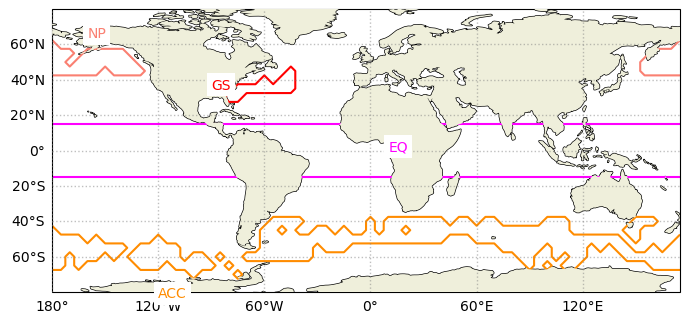

In [95]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(7,4))
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - wind term',]


label = r"Normalized pair's contribution $X_{ij}/\Sigma$"

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False

#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Distribution of colocalization per bins

In [96]:
min_coloc_bin = 30
ds['nb_coloc_bin'].attrs = {'long_name': 'Number of colocations per bin'}

Text(0.5, 0.8, 'Distribution')

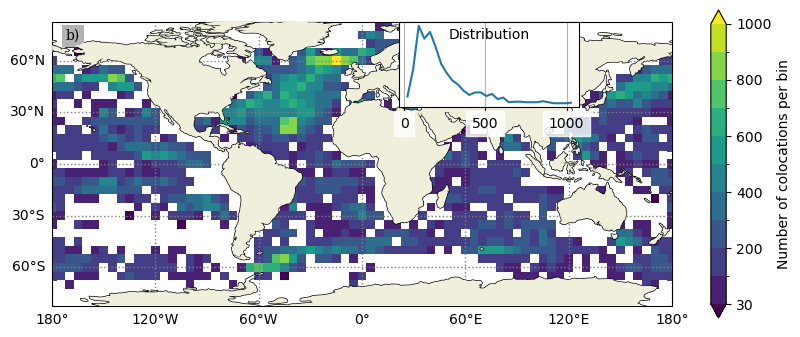

In [97]:
fig = plt.figure(figsize=(10,4), frameon=False)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin.plot(x='lonbin', y='latbin', cmap='viridis', levels=[min_coloc_bin]+list(np.arange(100, 1100, 100)), ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle=':', zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False

ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin, ins)
bbox = dict(ec="w", fc="w", alpha=0.8)
plt.setp(ins.get_xticklabels(), bbox=bbox)

put_fig_letter(fig, ax, 'b')

ins.grid()
ins.set_yticks([])
ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')

#fig.savefig('../images_all/lonlat_distrib.png',bbox_inches='tight',   dpi=300)

In [98]:
# GET CONTINENT MASK TO QUANTIFIED COVERAGED
proj = {'projection': ccrs.PlateCarree()}
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)
fig, ax = plt.subplots(figsize=(len(lon)/10000, len(lat)/10000), dpi=10000, subplot_kw=proj)
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
ax.set_frame_on(False)
ax.add_feature(cfeature.LAND, facecolor='black')
fig.canvas.draw()
mask = fig.canvas.tostring_rgb()
ncols, nrows = fig.canvas.get_width_height()
plt.close(fig)

mask = np.frombuffer(mask, dtype=np.uint8).reshape(nrows, ncols, 3)
mask = mask.mean(axis=2)
mask = np.flip(mask, axis=0)
mask = xr.DataArray(mask, coords={ 'latbin':lat, 'lonbin':lon,})
mask = mask.interp_like(ds)
mask = mask.where(mask==255, 0).where(mask!=255, 1)
d_mask = ds.where(test, 2).where(mask,1).acc
no_value = np.sum((d_mask== 2).values)
cont_value = np.sum((d_mask== 1).values)
full_value = np.sum((d_mask<1).values)
print(f'Coverage:{full_value/(full_value+no_value)*100}%')

Coverage:60.48652202498357%


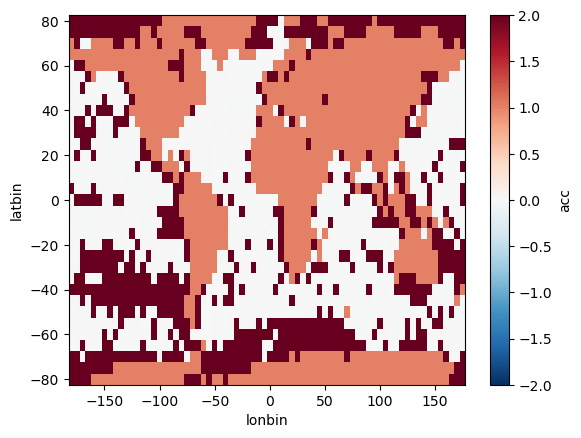

In [99]:
d_mask.plot()

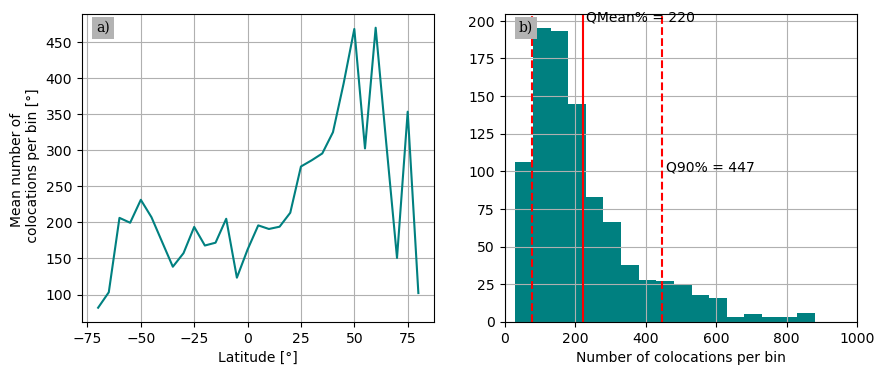

In [102]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax=axs[0]
ds.where(ds.nb_coloc_bin> 0).nb_coloc_bin.mean('lonbin').plot(ax=ax, c='teal')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Mean number of \n colocations per bin [°]')
ax.grid()
put_fig_letter(fig, ax, 'a')

ax =axs[1]
dd = 10
_ds = ds.where(ds.nb_coloc_bin> min_coloc_bin).nb_coloc_bin
hist = _ds.plot.hist(bins=np.arange(30,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)
put_fig_letter(fig, ax, 'b')

#fig.savefig('../images_all/lonlat_coloc_hist.png',  bbox_inches='tight',  dpi=300)

______________________
# Closure efficiancy : Residuals

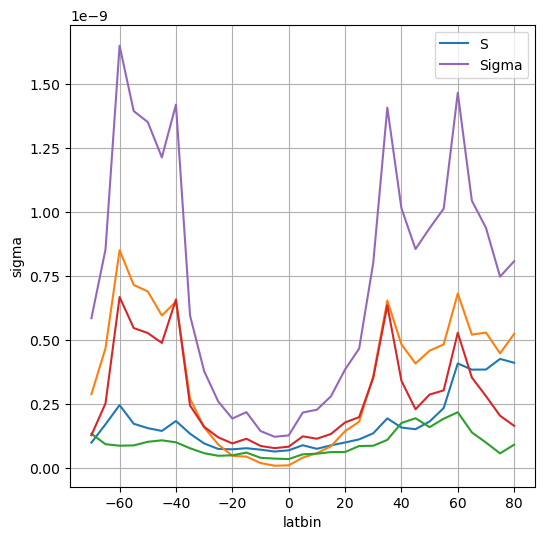

In [109]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ds['S'].mean(dim='lonbin').plot(ax=ax, label='S')
ds['COR'].mean(dim='lonbin').plot(ax=ax)
ds['ACC'].mean(dim='lonbin').plot(ax=ax)
ds['GGX'].mean(dim='lonbin').plot(ax=ax)
ds['sigma'].mean(dim='lonbin').plot(ax=ax, label='Sigma')
ax.legend()
ax.grid()

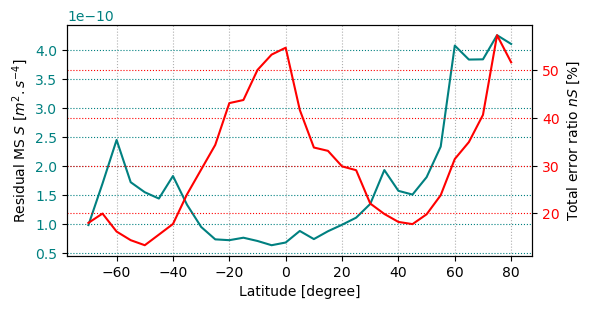

In [108]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
(ds['S']).mean(dim='lonbin').plot(ax=ax, label='nS', color='teal')
ax.set_xlabel('Latitude [degree]')
ax.set_ylabel(r'Residual MS $S$ [$m^2.s^{-4}$]')
ax.tick_params(axis='y', labelcolor='teal')
ax.grid(axis='y',color='teal', ls=':')
ax.grid(axis='x', ls=':')
ax2 = ax.twinx()
(ds['S']/ds['sigma']*100).mean(dim='lonbin').plot(ax=ax2, label='nS', color='r')
ax2.set_xlabel('Latitude [degree]')
ax2.set_ylabel(r'Total error ratio $nS$ [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.grid(axis='y',color='r',ls=':')
#fig.savefig('../images_all/lonlat_lat_hist_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)

Text(0, 0.5, '$\\Sigma$')

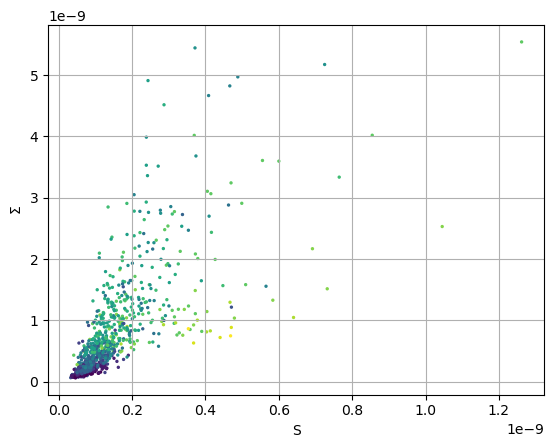

In [106]:
plt.scatter(ds['S'], ds['sigma'], c=np.array(np.abs(np.repeat(dsm.latbin, len(dsm.lonbin)))), s=2)
plt.grid()
plt.xlabel('S')
plt.ylabel(r'$\Sigma$')

Text(0, 0.5, 'nS')

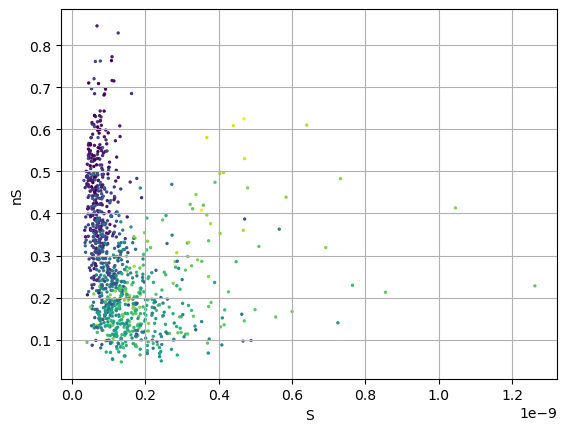

In [107]:
plt.scatter(ds['S'], ds['S']/ds['sigma'], c=np.array(np.abs(np.repeat(dsm.latbin, len(dsm.lonbin)))), s=2)
plt.grid()
plt.xlabel('S')
plt.ylabel('nS')

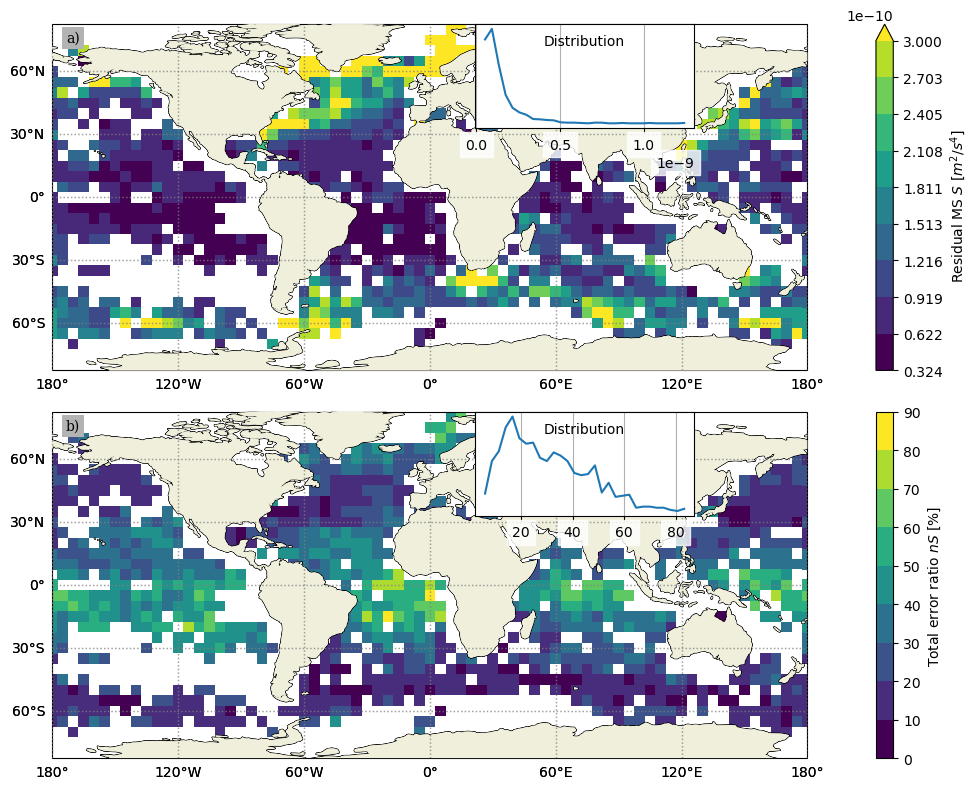

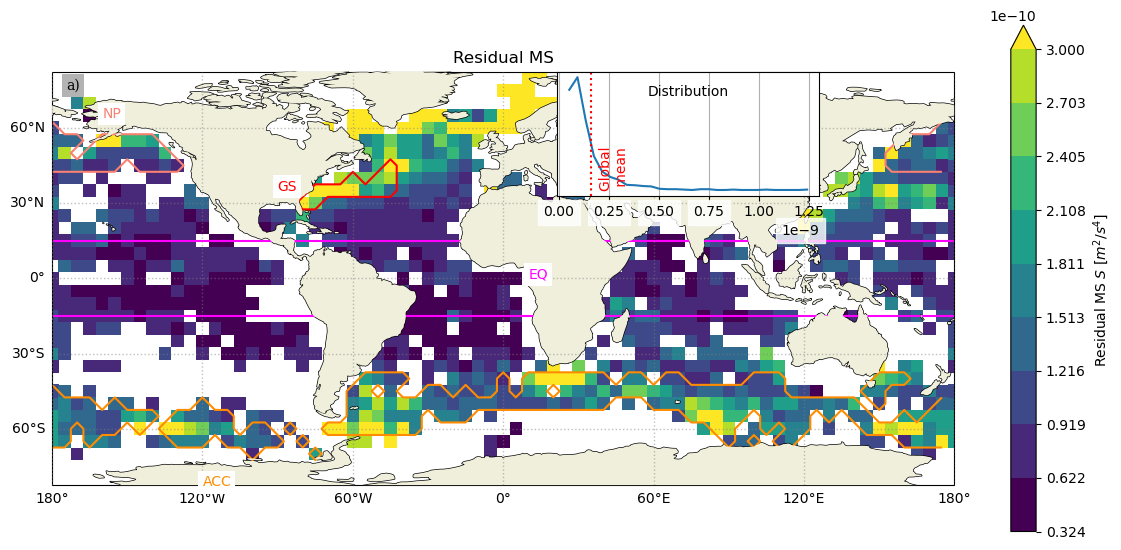

In [115]:
# CO 
fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8), frameon=False)
ax = axs[0]
ds['S'].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(ds['S'],ax, 'a', vmax = 3e-10, levels=10, retins=True)
#ds['S'].plot.contour(ax=ax, levels=[2e-10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(2e-10, color = 'r')
#ds['S'].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')

ax = axs[1]
nmsre = (ds['S']/ds['sigma']*100).assign_attrs({'long_name': r'Total error ratio $nS$ [%]'})
plot_lonlat(nmsre,ax, 'b', levels=10)
#ds['S'].plot.contour(ax=ax, levels=[2e-10], colors=['red'])


for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)


## S Alone
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), frameon=False)
ds['S'].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(ds['S'],ax, '', vmax = 3e-10, levels=10, retins=True)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10], colors=['red'])
ins.axvline(1.6e-10, color = 'r', ls=':')
ins.annotate('Global \n mean',( 2e-10, 5), color='r', rotation=90)

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=3)
ax.set_title('Residual MS')
put_fig_letter(fig, ax, 'a')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_msre_alg.png', bbox_inches='tight',   dpi=300)

for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_msre_nmsre_aviso.png', bbox_inches='tight',   dpi=300)

## Sum of individual term MSs $\Sigma$

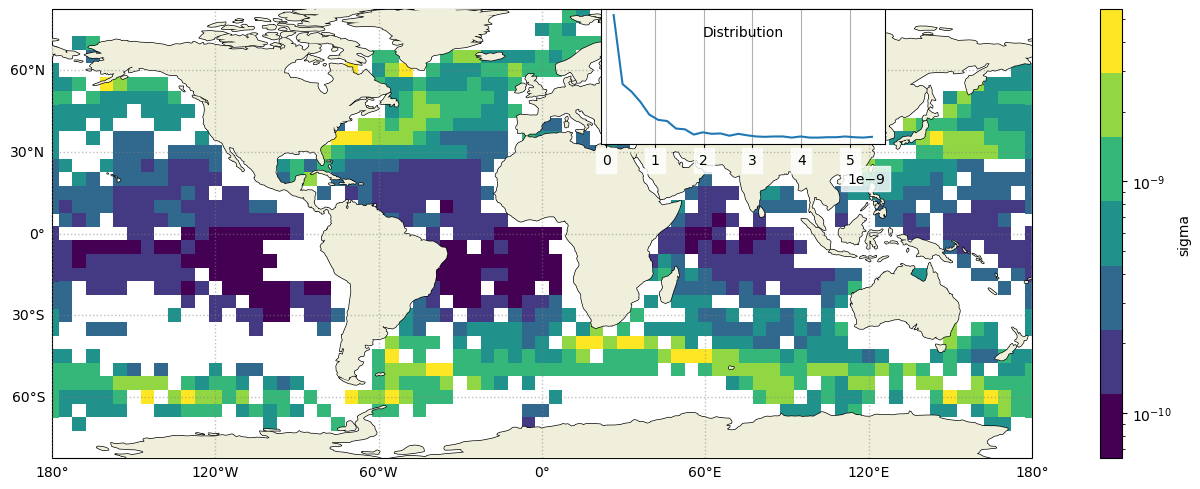

In [116]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
#ds['S'].plot.contour(ax=ax, levels=[2e-10], colors=['red'], transform=ccrs.PlateCarree())
plot_lonlat(ds['sigma'],ax, levels=10, norm=colors.LogNorm(vmin=ds['sigma'].min(), vmax=ds['sigma'].max()))
#ds['S'].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_sigma_alg.png', bbox_inches='tight',   dpi=300)


## Relative error on the residual

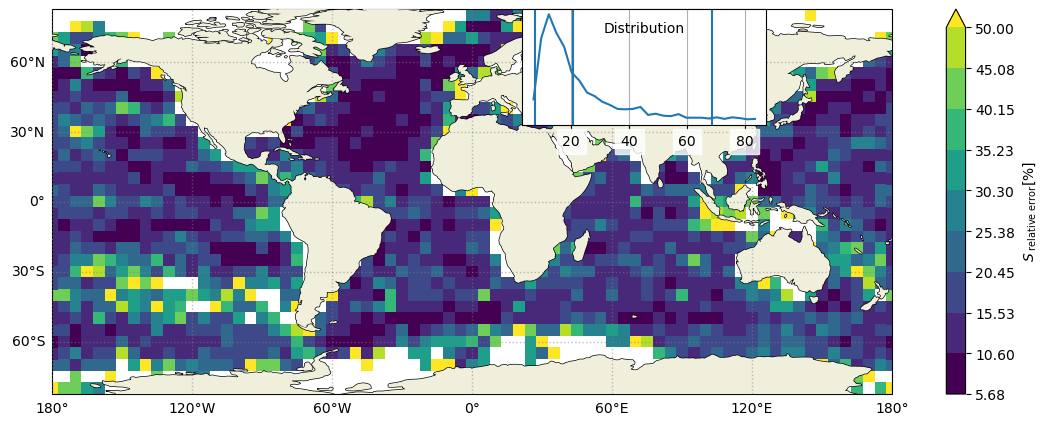

In [126]:
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dsm['ratio__S']*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ins = plot_lonlat(ne, ax,'', levels=10,vmax=50, retins=True)
#mean, quartile
ne_ = ne.values.ravel()
ne_ = ne_[~np.isnan(ne_)]
ins.axvline(ne_.mean())
ins.axvline(np.percentile(ne_, 1))
ins.axvline(np.percentile(ne_, 99))
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
#fig.savefig('../images_all/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


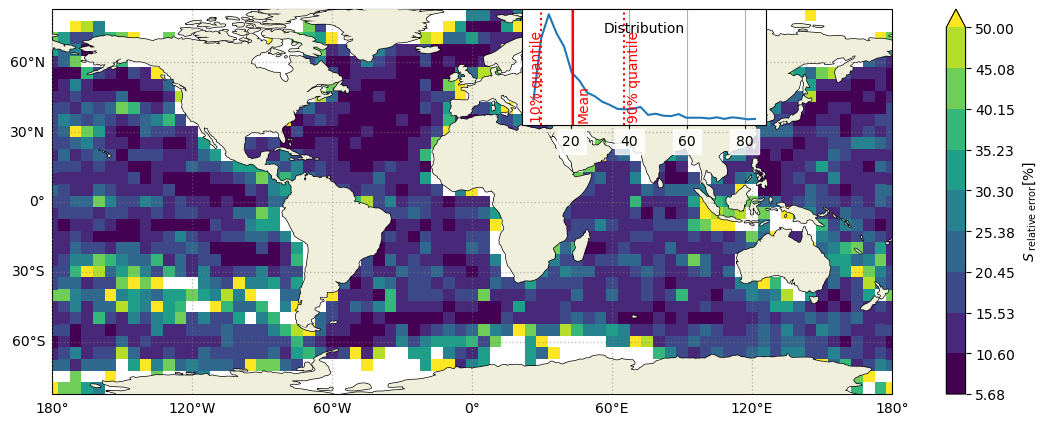

In [130]:
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dsm['ratio__S']*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ins = plot_lonlat(ne, ax,'', levels=10,vmax=50, retins=True)

#mean, quartile
ne_ = ne.values.ravel()
ne_ = ne_[~np.isnan(ne_)]
ins.axvline(ne_.mean(), c='r')
ins.annotate('Mean',(ne_.mean()+1, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 10), ls=':', c='r')
ins.annotate('10% quantile',(np.percentile(ne_, 10)-4, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 90), ls=':', c='r')
ins.annotate('90% quantile',(np.percentile(ne_, 90)+1, 1), color='r', rotation=90)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
#fig.savefig('../images_all/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


Text(0.5, 1.0, 'Along-track')

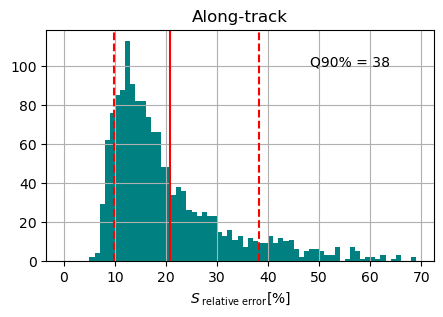

In [131]:
dd = 10
_ds = ds.where(ds.nb_coloc_bin >0).nb_coloc_bin
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = ne.plot.hist(bins=np.arange(0,70, 1), ax=ax, color='teal')
mean = ne.mean().values
q90 = ne.quantile(0.9).values
q10 = ne.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_title('Along-track')

______________________
# Pairs contribution


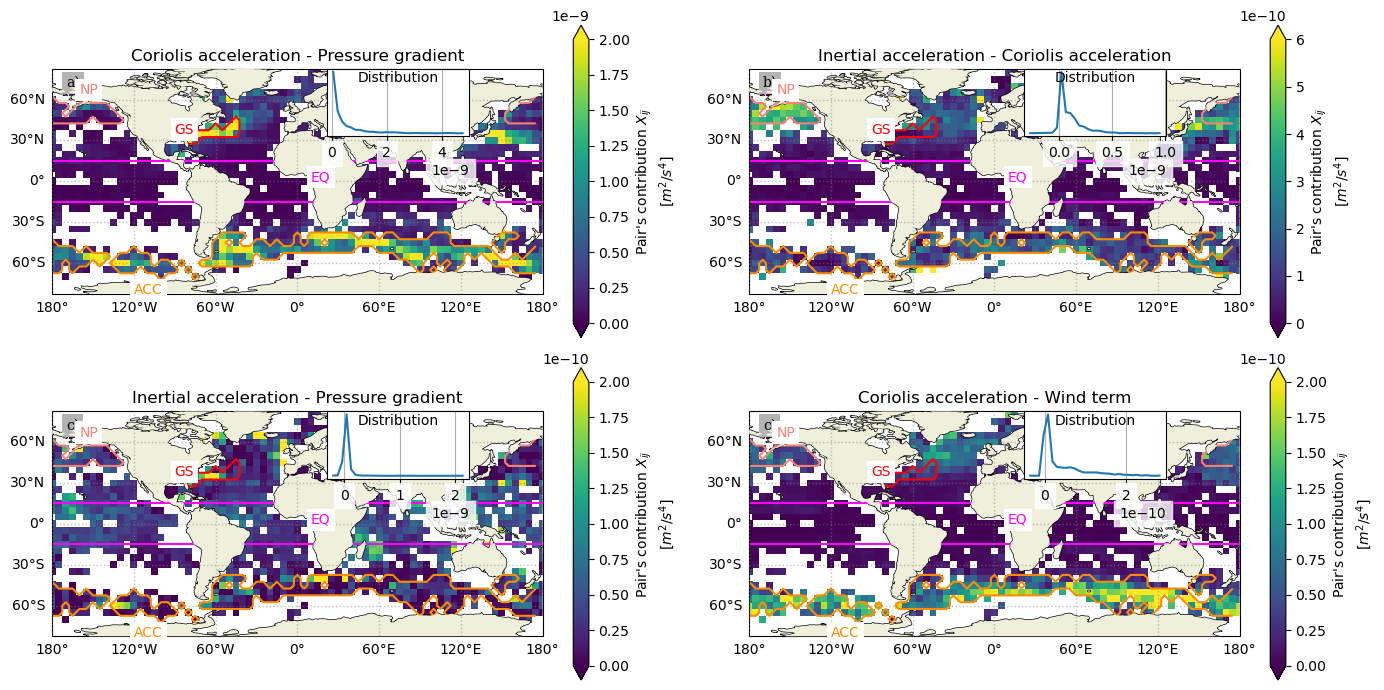

In [135]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis acceleration - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
ds['X_cor_ggx'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_cor_ggx'], ax, 'a', vmin = 0, vmax=2e-9,)
plot_areas(ax)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_cor'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_acc_cor'], ax, 'b', vmin = 0, vmax=6e-10,)
plot_areas(ax)
ax.set_title(title[1])

ax=axs[2]
ds['X_acc_ggx'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_acc_ggx'], ax, 'c', vmin = 0, vmax = 2e-10,)
plot_areas(ax)
ax.set_title(title[2])

ax=axs[3]
ds['X_cor_wd'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_cor_wd'], ax, 'c', vmin = 0, vmax = 2e-10,)
plot_areas(ax)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_pair_alg.png', bbox_inches='tight',   dpi=300)


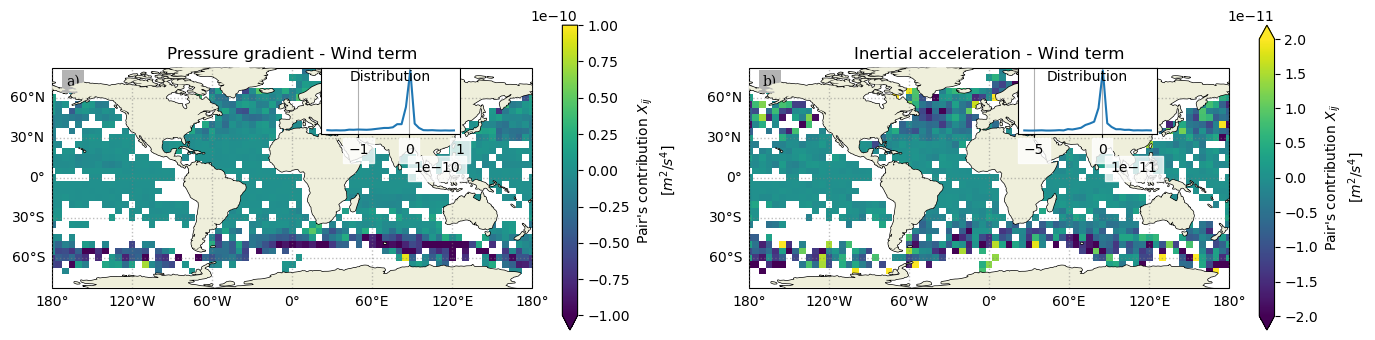

In [137]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,3.5), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Inertial acceleration - Wind term']
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
ds['X_ggx_wd'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_ggx_wd'], ax, 'a',vmin = -1e-10, vmax = 1e-10,)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_wd'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(ds['X_acc_wd'], ax, 'b',vmin = -2e-11, vmax =2e-11,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_other_pair_alg.png', bbox_inches='tight',   dpi=300)


## Contribution normalized by $\Sigma$

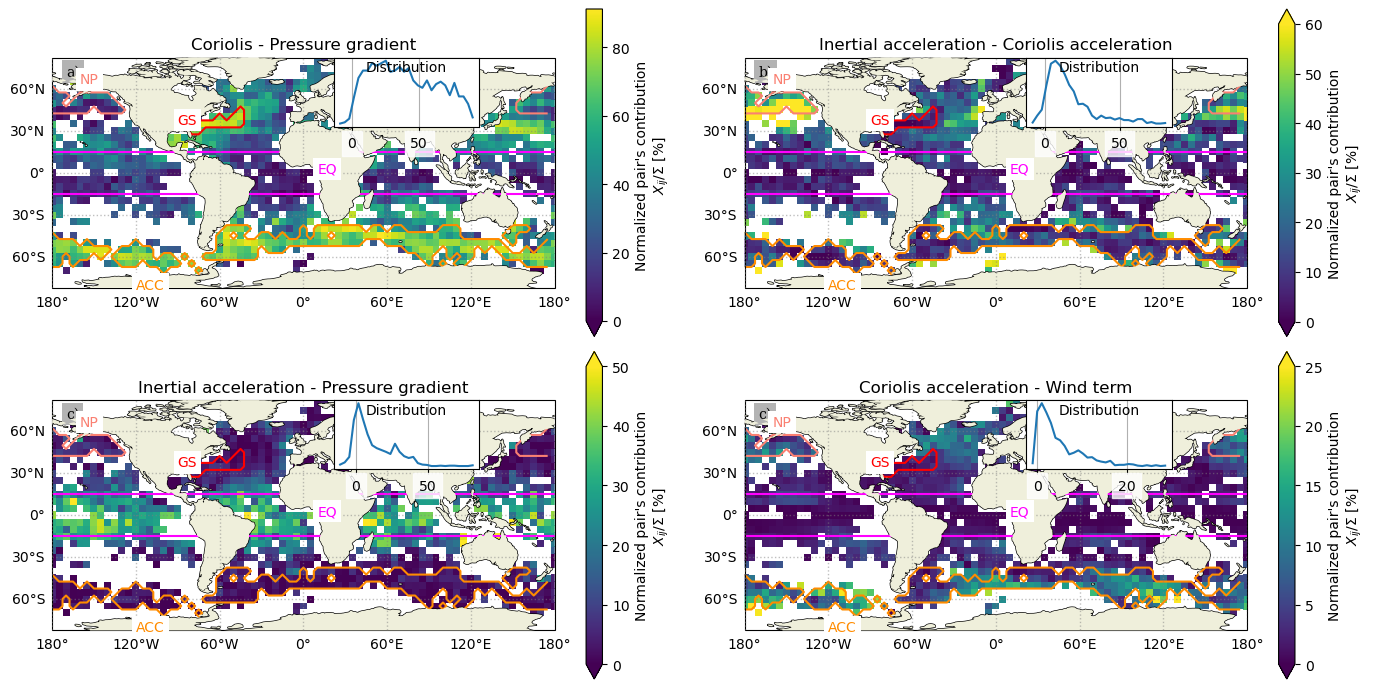

In [143]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
ds['X_cor_ggx__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_cor_ggx__sigma'], ax, 'a', vmin = 0, retins=True)
plot_areas(ax)
#dsm['X_cor_ggx'].plot.contour(ax=ax, levels=[70], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(70, color = 'r')
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_cor__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_acc_cor__sigma'], ax, 'b', vmin = 0, vmax=60, retins=True)
plot_areas(ax)
#dsm['X_acc_cor'].plot.contour(ax=ax, levels=[60], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(60, color = 'r')
ax.set_title(title[1])


ax=axs[2]
ds['X_acc_ggx__sigma'].attrs={'long_name':label, 'unit':'%'}
ins= plot_lonlat(ds['X_acc_ggx__sigma'], ax, 'c', vmin = 0, vmax=50, retins=True)
#dsm['X_acc_ggx'].plot.contour(ax=ax, levels=[25], colors=['red'], transform=ccrs.PlateCarree())
plot_areas(ax)
#acc.plot.contour(ax=ax, levels=1, colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(30, color = 'r')
ax.set_title(title[2])

ax=axs[3]
ds['X_cor_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(ds['X_cor_wd__sigma'], ax, 'c', vmin = 0, vmax=25, retins=True)
plot_areas(ax)
#dsm['X_cor_wind'].plot.contour(ax=ax, levels=[10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(10, color = 'r')
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_pair_normalized_alg.png',  bbox_inches='tight',  dpi=300)

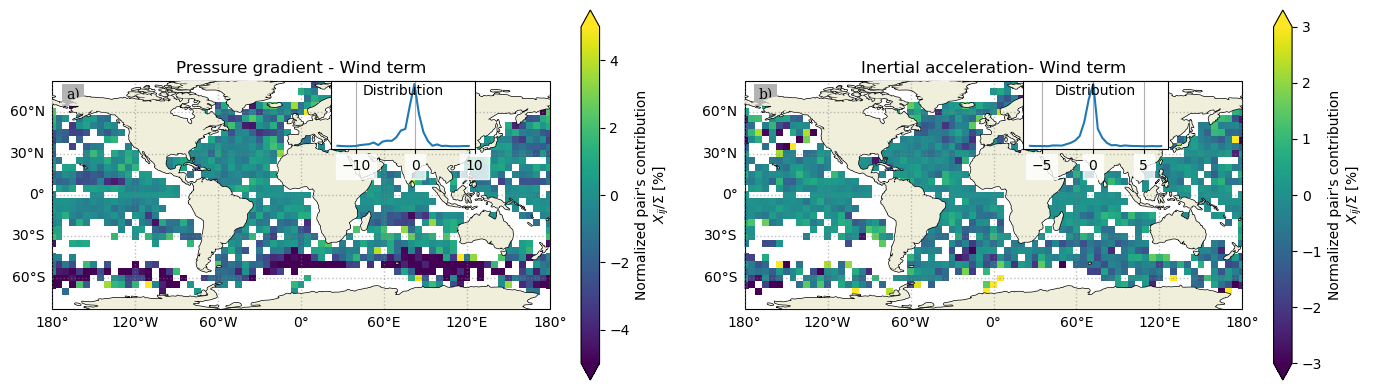

In [146]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,4), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Inertial acceleration- Wind term']
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
ds['X_ggx_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(ds['X_ggx_wd__sigma'], ax, 'a',vmin = -5, vmax = 5,)
ax.set_title(title[0])

ax=axs[1]
ds['X_acc_wd__sigma'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(ds['X_acc_wd__sigma'], ax, 'b',vmin = -3, vmax = 3,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_other_pair_normalized_alg.png', bbox_inches='tight',   dpi=300)

In [147]:
ds

<xarray.Dataset>
Dimensions:                 (latbin: 33, lonbin: 72)
Coordinates:
  * latbin                  (latbin) float64 -80.0 -75.0 -70.0 ... 75.0 80.0
  * lonbin                  (lonbin) float64 -180.0 -175.0 ... 170.0 175.0
Data variables: (12/47)
    obs                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    acc                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    cor                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    drogue_status           (latbin, lonbin) float64 nan nan nan ... nan nan nan
    ggx                     (latbin, lonbin) float64 nan nan nan ... nan nan nan
    wd                      (latbin, lonbin) float64 nan nan nan ... nan nan nan
    ...                      ...
    X_acc_ggx__sigma        (latbin, lonbin) float64 nan nan nan ... nan nan nan
    X_acc_wd__sigma         (latbin, lonbin) float64 nan nan nan ... nan nan nan
    X_cor_ggx__sigma        (latbin, lonbin) float64 nan nan nan ... nan nan nan
    X_cor_wd__sigma         (latbin, lonbin) float64 nan nan nan ... nan nan nan
    X_ggx_wd__sigma         (latbin, lonbin) float64 nan nan nan ... nan nan nan
    GGX__sigma              (latbin, lonbin) float64 nan nan nan ... nan nan nan

________________________
# Balanced/errors parts

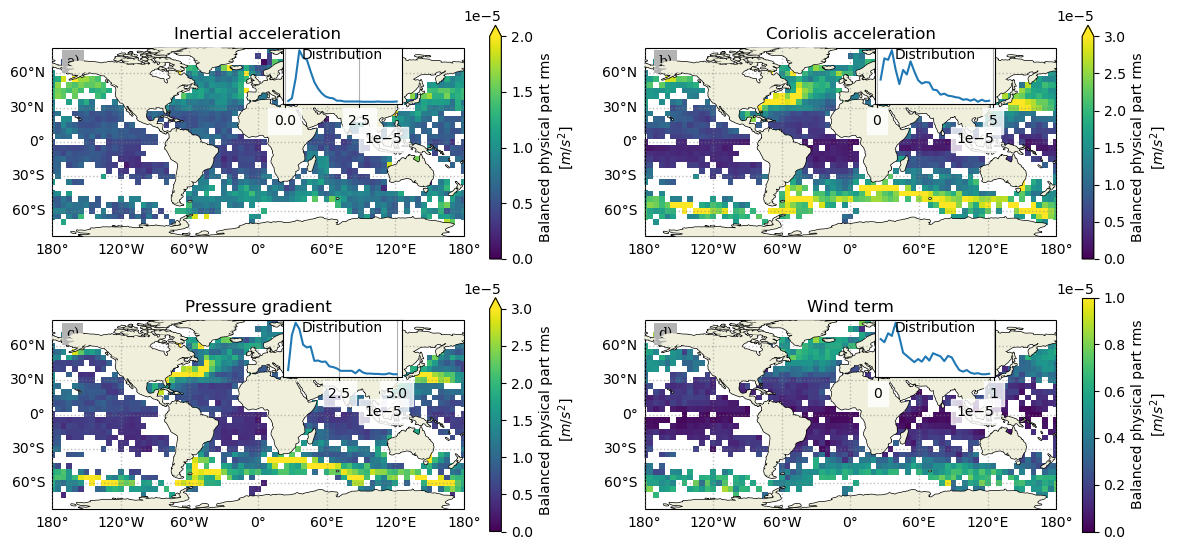

In [150]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Balanced physical part rms'

ax=axs[0]
ds['B_acc'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(ds['B_acc']), ax, 'a', vmin = 0, vmax=2e-5)
ax.set_title('Inertial acceleration')

ax=axs[1]
ds['B_cor'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(ds['B_cor']), ax, 'b', vmin = 0, vmax=3e-5)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds['B_ggx'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(ds['B_ggx']), ax, 'c', vmin = 0, vmax=3e-5,)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['B_wd'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(ds['B_wd']), ax, 'd', vmin = 0, vmax=1e-5,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

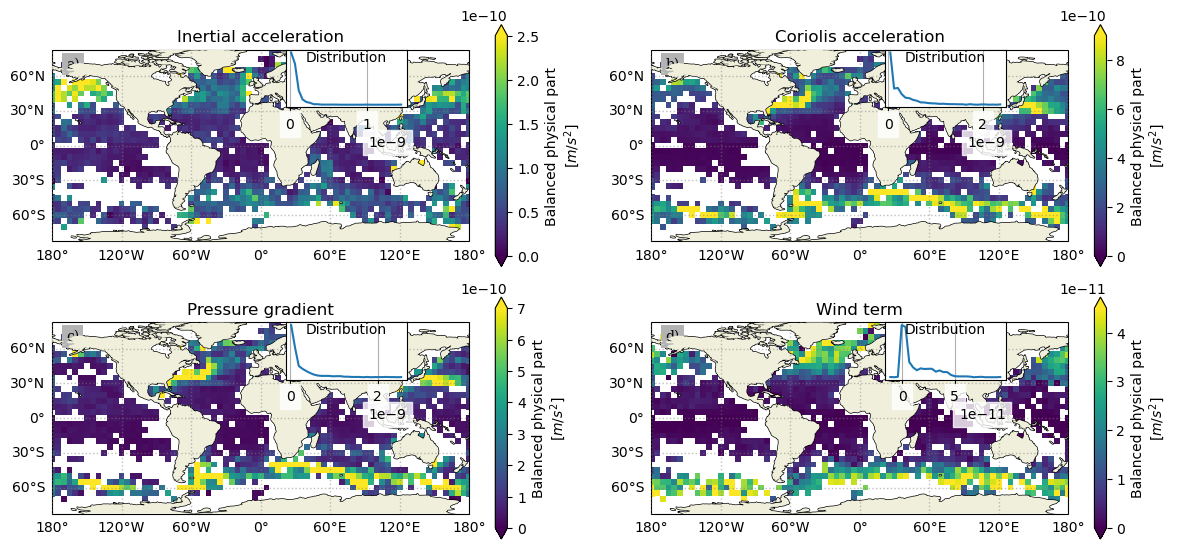

In [153]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Balanced physical part'

ax=axs[0]
ds['B_acc'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['B_acc'], ax, 'a', vmin =0, vmax=2.5e-10,)
ax.set_title('Inertial acceleration')

ax=axs[1]
ds['B_cor'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['B_cor'], ax, 'b', vmin = 0, vmax=9e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds['B_ggx'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['B_ggx'], ax, 'c', vmin = 0, vmax=7e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['B_wd'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['B_wd'], ax, 'd', vmin = 0, vmax=4.5e-11,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

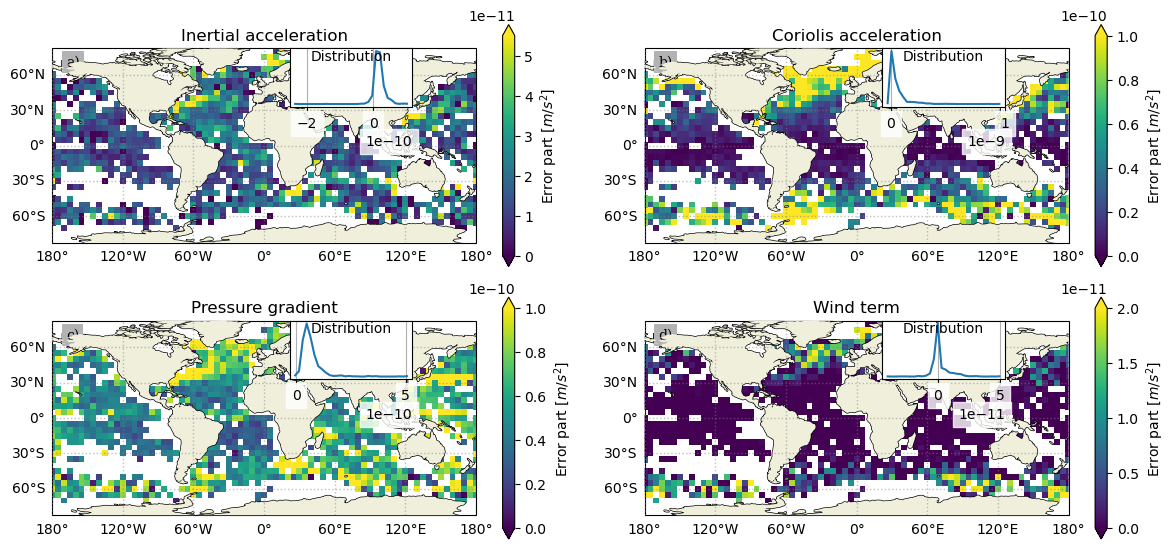

In [155]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Error part'

ax=axs[0]
ds['E_acc'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['E_acc'], ax, 'a', vmin =0, vmax=5.5e-11,)
ax.set_title('Inertial acceleration')

ax=axs[1]
ds['E_cor'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['E_cor'], ax, 'b', vmin = 0, vmax=1e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
ds['E_ggx'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['E_ggx'], ax, 'c', vmin = 0, vmax=1e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
ds['E_wd'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(ds['E_wd'], ax, 'd', vmin = 0, vmax=2e-11,)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

## Check for colocalization mismatch errors 

Text(0.5, 1.0, 'Pressure gradient error - coriolis errors')

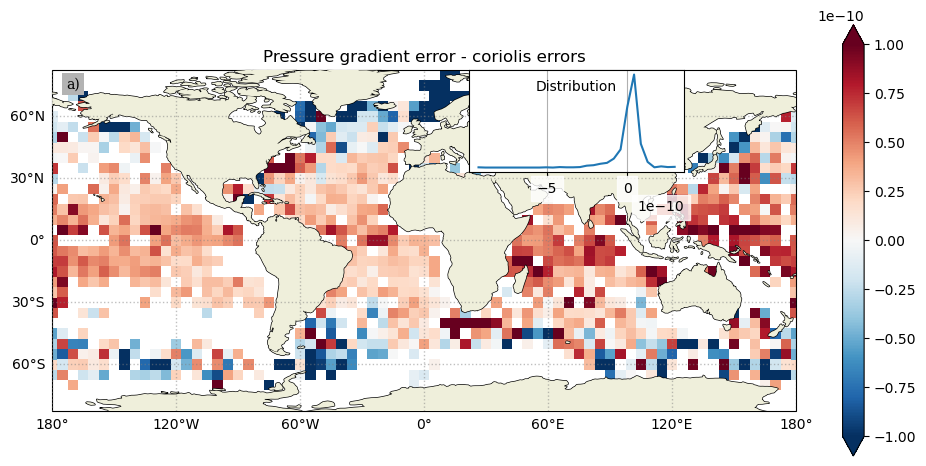

In [156]:
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,5.6), sharex=True, sharey=True, frameon=False)

plot_lonlat((ds['E_ggx']-ds['E_cor']), ax, 'a', vmin = -1e-10, vmax=1e-10, cmap='RdBu_r')
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('Pressure gradient error - coriolis errors')

_________
# Diagnostics in areas

## Build dataset

In [159]:
def mean_area(ds):
    ds_= (((ds*ds.nb_coloc_bin).sum(['lonbin', 'latbin']))/(ds.nb_coloc_bin.sum(['lonbin', 'latbin'])))
    for v in ds.keys():
        if v != 'nb_coloc':
            ds_[v].attrs=ds[v].attrs
    
    #nb_coloc
    nb_coloc = ds.nb_coloc_bin.sum()
    ds_['nb_coloc']= nb_coloc
    
    return ds_

In [65]:
dsmss_ = mean_area(dsmss.where(acc))
ds = mean_area(ds.where(acc))



## Synthetic figures

In [175]:
ds_.set_coords('obs').expand_dims('obs').to_dataframe()

acc       cor  drogue_status       ggx            wd  \
obs                                                                           
48250.378086 -1.169506e-07 -0.000001            1.0  0.000002 -3.943543e-08   

              alti___distance  alti___time_difference        lat        lon  \
obs                                                                           
48250.378086     12602.323459              918.297022  38.606942 -56.128592   

                         s  ...         be__S  ratio__S  X_acc_cor__sigma  \
obs                         ...                                             
48250.378086  2.278477e-07  ...  3.534110e-11  0.111901          3.773342   

              X_acc_ggx__sigma  X_acc_wd__sigma  X_cor_ggx__sigma  \
obs                                                                 
48250.378086          3.312668        -0.221306         80.165339   

              X_cor_wd__sigma  X_ggx_wd__sigma  GGX__sigma  nb_coloc  
obs                                                                   
48250.378086          1.60517        -0.359999   47.332164    6279.0  

[1 rows x 47 columns]

GS
2.8204293659410845e-09
2.8621798358319517e-09
ACC
1.6258594929593088e-09
1.6954110221030193e-09
NP
8.095348352043789e-10
8.246058322241002e-10
EQ
1.7099192856805013e-10
1.7331284549758962e-10


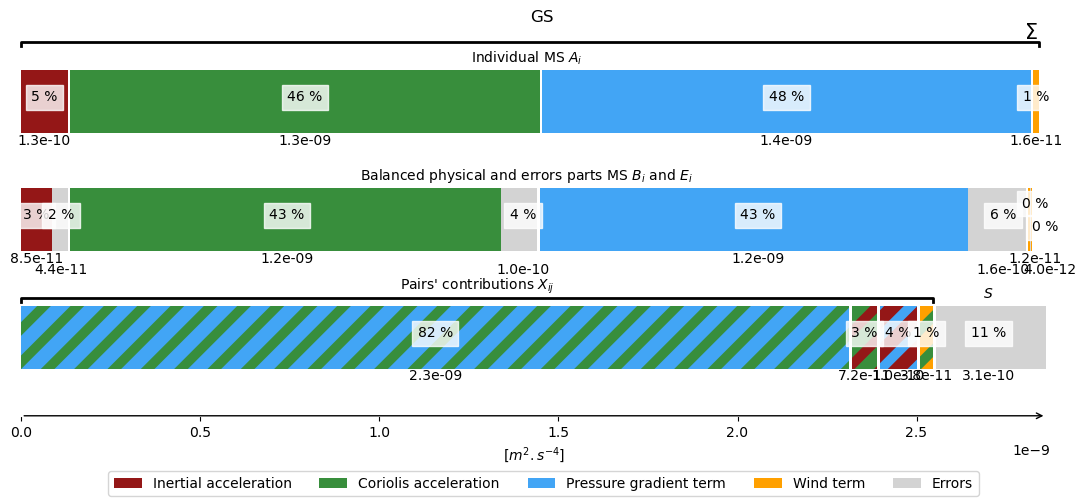

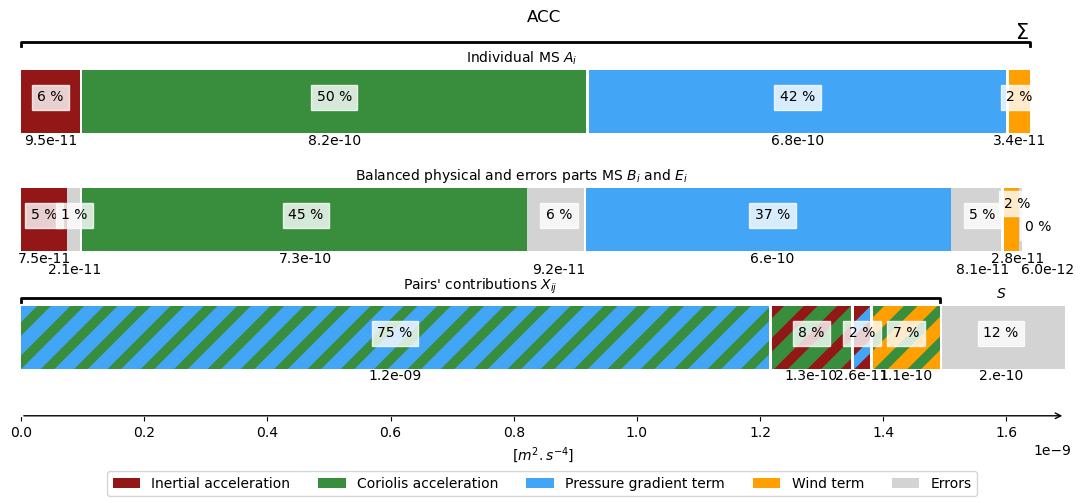

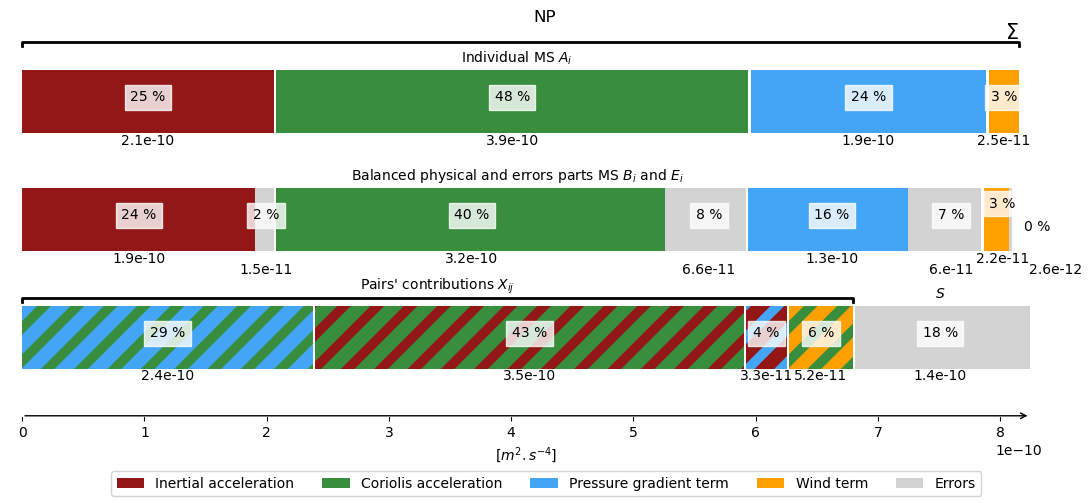

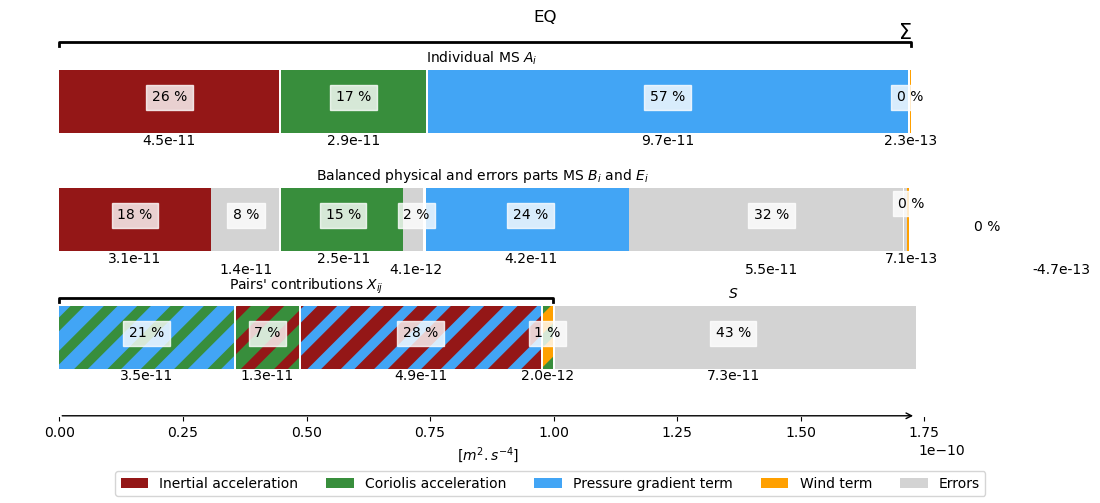

In [192]:
for area in areas:
    print(area)
    ds_ = mean_area(ds.where(areas[area]))
    plt.rcParams["axes.edgecolor"] = "w"
    df_ = ds_.set_coords('obs').expand_dims('obs').to_dataframe().mean()
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False,)
    synthetic_figure(df_, ax)#, xlim=2.5e-9) 
    fig.legend(ncol=5,loc='lower center')
    fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(area)
    #fig.savefig(f"../images_all/synth_alg{area.replace(' ','_')}.png",bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"

In [193]:
handles, labels = ax.get_legend_handles_labels()

GS
ACC
NP
EQ


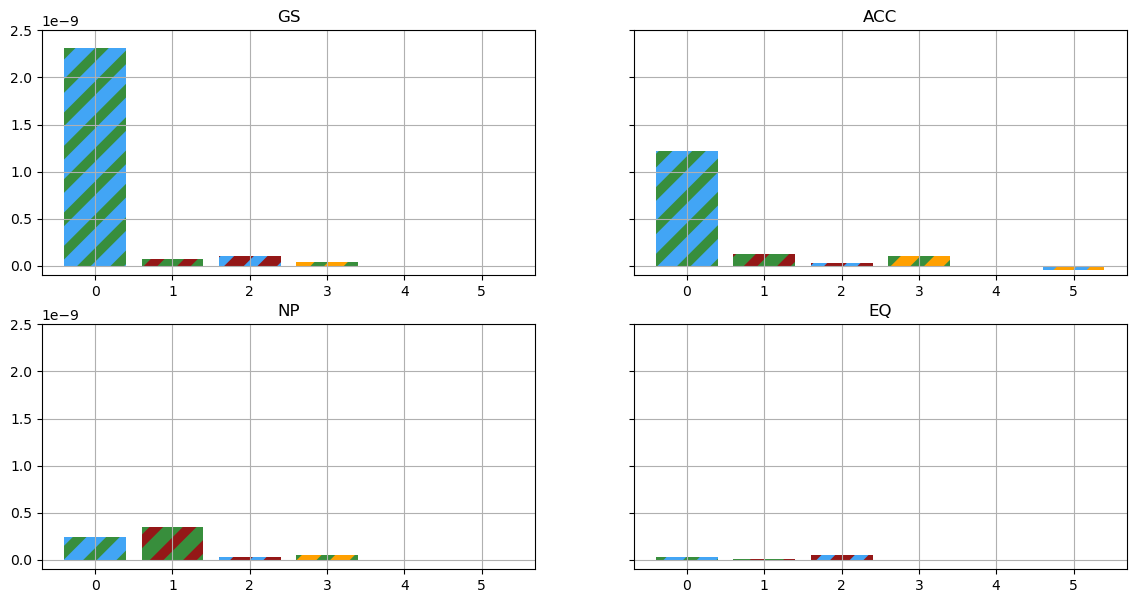

In [202]:
plt.rcParams["axes.edgecolor"] = "k"

fig, axs = plt.subplots(2,2, sharey=True, figsize=(14,7))

axs = axs.flatten()
i=0
for area in areas:
    print(area)
    ds_ = mean_area(ds.where(areas[area]))
    ax=axs[i]
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.bar(0, ds_['X_cor_ggx'], color=c0['coriolis'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.bar(1, ds_['X_acc_cor'], color=c0['acc'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.bar(2, ds_['X_acc_ggx'], color=c0['ggrad'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(3, ds_['X_cor_wd'], color=c0['coriolis'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(4, ds_['X_acc_wd'], color=c0['acc'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(5, ds_['X_ggx_wd'], color=c0['ggrad'], hatch='/', capsize=10 )
    ax.grid()
    ax.set_ylim(-1e-10, 2.5e-9)
    ax.set_title(area)
    i+=1

In [206]:
def synthetic_figure_3lineonly(ds, ax, xlim=None, pb_text=False, aviso=False) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    
    ts = ds['sigma']
    
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400

    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, ds['X_cor_ggx'], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, ds['X_acc_cor'], color=c0['acc'], hatch='/', left = ds['X_cor_ggx']+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, ds['X_acc_ggx'], color=c0['ggrad'], hatch='/', left = ds['X_cor_ggx']+ds['X_acc_cor']+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, ds['X_cor_wd'], color=c0['coriolis'], hatch='/', left = ds['X_cor_ggx']+ds['X_acc_cor']+ds['X_acc_ggx']+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = ds['X_cor_ggx']+ds['X_acc_cor']+ds['X_acc_ggx']+ds['X_cor_wd']+4*b)

    tts = ds['X_cor_ggx']+ds['X_acc_cor']+ds['X_acc_ggx']+ds['X_cor_wd']+4*b+ds['S']
    print(tts)
    sum_pairs = ds['X_cor_ggx']+ds['X_acc_cor']+ds['X_acc_ggx']+ds['X_cor_wd']+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = ['X_cor_ggx','X_acc_cor', 'X_acc_ggx', 'X_cor_wd']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 0, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if aviso and key[i]== 'X_acc_ggx' : d = -0.1*a
        if pb_text and key[i]== 'X_acc_ggx':d=1.1
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 0-0.6+d, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([ds[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([ds[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    #ax.set_xlim(-1e-11, xlim+1e-11)
    yax=-0.8
    ax.set_ylim(yax, 0.5)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,yax),xytext=(0, yax),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

<xarray.DataArray ()>
array(2.86217984e-09)
<xarray.DataArray ()>
array(1.69541102e-09)
<xarray.DataArray ()>
array(8.24605832e-10)
<xarray.DataArray ()>
array(1.73312845e-10)


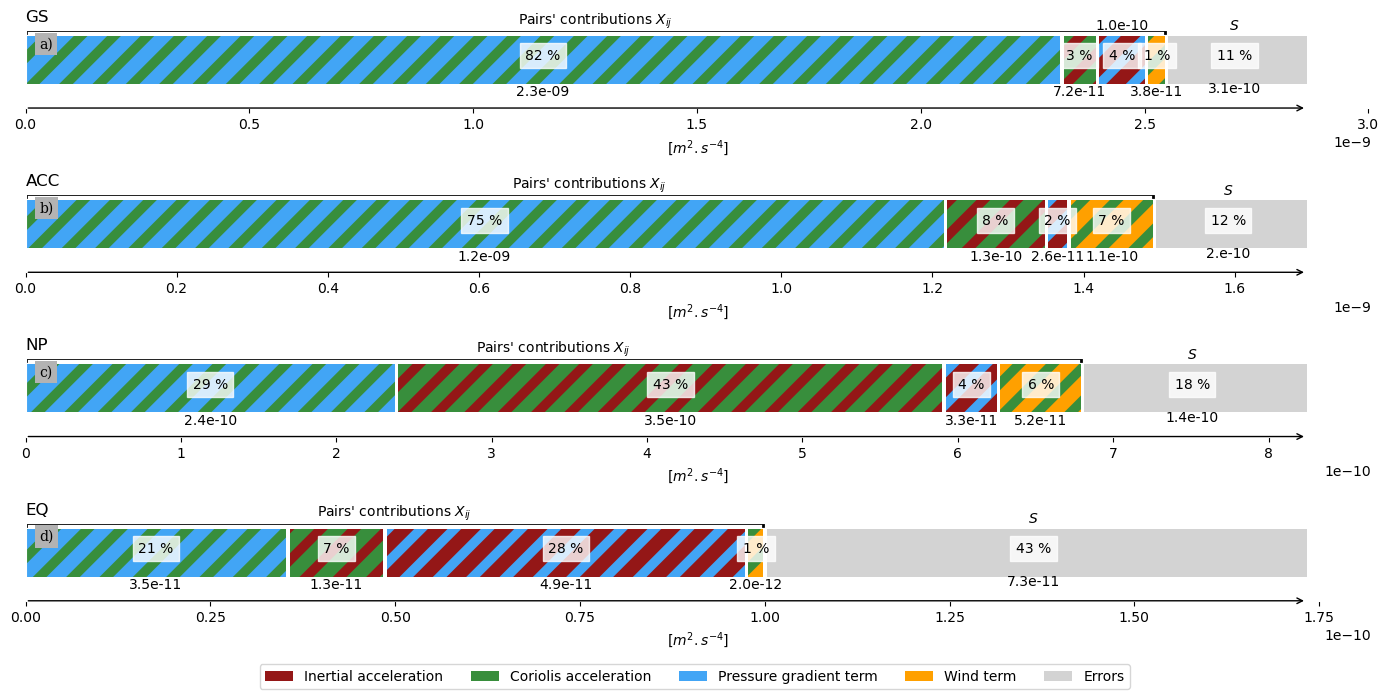

In [214]:
plt.rcParams["axes.edgecolor"] = "w"
fig, axs = plt.subplots(4,1, figsize=(14,7))

axs = axs.flatten()
i=0
pb_text=True
letter=['a', 'b', 'c', 'd']
for area in areas:
    ax=axs[i]
    ds_ = mean_area(ds.where(areas[area]))
    synthetic_figure_3lineonly(ds_, ax, pb_text=pb_text)#, xlim=2.5e-9) 
    ax.set_title(area, loc='left')
    #ax.set_xlabel('')
    put_fig_letter(fig, ax, letter[i])
    i+=1
    pb_text=False

#ax.set_xlabel(r'$[m^2.s^{-4}]$')
fig.legend(handles=handles, labels=labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_synth3line_in_areas_alg.png', bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"